## mercariの値段予測モデル

kaggleにあるmercariのデータを利用しました
https://www.kaggle.com/saitosean/mercari

テストデータの正しい値段のデータが見当たらなかったので、\
train.tsvを学習データとテストデータに分けています。

### 工夫点

・対数変換を用いて、正規分布に近づける\
・欠損値処理（特にブランド名と商品名の関連に注目して処理した）\
・Embedding層でのベクトル化\
・再帰層にGRUを用いる

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_table('./train.tsv')
print(train_df.shape)

(1482535, 8)


In [3]:
train_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


訓練データとテストデータに分ける

In [4]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    train_df,
    train_size=0.6,
    test_size=0.4)

print(train_df.shape)
print(test_df.shape)

(889521, 8)
(593014, 8)


In [5]:
train_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
1055014,1055014,Nike pro youth leggins,2,Kids/Boys (4+)/Top & T-shirts,Nike,12.0,0,size youth large worn 1 time! Will ship asap! ...
213969,213969,Summer VS PINK,2,Women/Tops & Blouses/T-Shirts,PINK,4.0,1,Reserved listing
1169222,1169222,Black Embroidered Sheer Lace Tunic Dress,3,"Women/Dresses/Above Knee, Mini",NaN,12.0,0,New without tags. This dress can also be used ...
698204,698204,Adrell eyelashes,1,Beauty/Makeup/Eyes,NaN,12.0,1,Ardell single eyelashes new Ardell glue and re...
1385834,1385834,Nwt Wen 4 piece hair care bundle,1,Beauty/Hair Care/Shampoo & Conditioner Sets,NaN,40.0,0,The bundle includes one lavender cleansing con...


In [6]:
test_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
363400,363400,ABH Crush Liquid Lipstick,1,Beauty/Makeup/Lips,Anastasia Beverly Hills,17.0,1,This Anastasia Beverly Hills liquid lipstick g...
1475289,1475289,Holo Flareon EX,2,Vintage & Collectibles/Trading Cards/Animation,Pokemon,3.0,1,"Holo Flareon EX!! Mint, Will ship in card sleeve."
593583,593583,NARS Orgasm Blush,1,Beauty/Makeup/Face,Nars,18.0,1,✨ New and unused ✨ Full size ✨ Authentic -- fr...
1405366,1405366,321justin orioles,1,Sports & Outdoors/Fan Shop/MLB,NaN,74.0,0,"All Oriole's.. Boy bobble head, XL hoodie, soc..."
724901,724901,Michael kors crossbody,4,Women/Women's Handbags/Messenger & Crossbody,Michael Kors,24.0,0,Grey crossbody has two zipper parts that you c...


テストデータの'price'を削除して、テストデータとして利用できる様にする

In [7]:
test_dfs = test_df
test_df = test_df.drop('price', axis=1)
test_df.head()

,train_id,name,item_condition_id,category_name,brand_name,shipping,item_description
363400,363400,ABH Crush Liquid Lipstick,1,Beauty/Makeup/Lips,Anastasia Beverly Hills,1,This Anastasia Beverly Hills liquid lipstick g...
1475289,1475289,Holo Flareon EX,2,Vintage & Collectibles/Trading Cards/Animation,Pokemon,1,"Holo Flareon EX!! Mint, Will ship in card sleeve."
593583,593583,NARS Orgasm Blush,1,Beauty/Makeup/Face,Nars,1,✨ New and unused ✨ Full size ✨ Authentic -- fr...
1405366,1405366,321justin orioles,1,Sports & Outdoors/Fan Shop/MLB,NaN,0,"All Oriole's.. Boy bobble head, XL hoodie, soc..."
724901,724901,Michael kors crossbody,4,Women/Women's Handbags/Messenger & Crossbody,Michael Kors,0,Grey crossbody has two zipper parts that you c...


メルカリで３ドル以下の出品はできないので３ドル以下のデータは除く

In [8]:
train_df = train_df.drop(train_df[(train_df.price < 3.0)].index)
train_df.shape

(889005, 8)

商品名と商品説明の単語数を登録

In [9]:
def wordCount(text):
    try:
        if text == 'No description yet':
            return 0  
        else:
            text = text.lower()                  
            words = [w for w in text.split(" ")] 
            return len(words)                    
    except: 
        return 0

train_df['name_len'] = train_df['name'].apply(lambda x: wordCount(x))
test_df['name_len'] = test_df['name'].apply(lambda x: wordCount(x))

train_df['desc_len'] = train_df['item_description'].apply(lambda x: wordCount(x))
test_df['desc_len'] = test_df['item_description'].apply(lambda x: wordCount(x))

対数変換によって、正規分布に近づける

<AxesSubplot:>

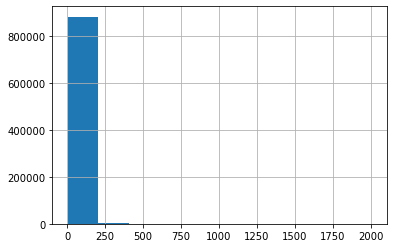

In [10]:
train_df['price'].hist()

<AxesSubplot:>

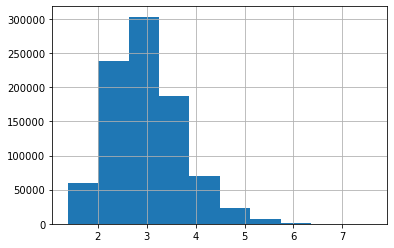

In [11]:
train_df['target']=np.log1p(train_df.price)
train_df['target'].hist()

'category_name'を3つに分ける

In [12]:
def split_cat(text):
    try: return text.split('/')
    except: return ('No Label', 'No Label', 'No Label')
    
train_df['subcat_0'], train_df['subcat_1'], train_df['subcat_2'] = zip(*train_df['category_name'].apply(lambda x: split_cat(x)))
test_df['subcat_0'], test_df['subcat_1'], test_df['subcat_2'] = zip(*test_df['category_name'].apply(lambda x: split_cat(x)))

In [13]:
train_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,name_len,desc_len,target,subcat_0,subcat_1,subcat_2
1055014,1055014,Nike pro youth leggins,2,Kids/Boys (4+)/Top & T-shirts,Nike,12.0,0,size youth large worn 1 time! Will ship asap! ...,4,11,2.564949,Kids,Boys (4+),Top & T-shirts
213969,213969,Summer VS PINK,2,Women/Tops & Blouses/T-Shirts,PINK,4.0,1,Reserved listing,3,2,1.609438,Women,Tops & Blouses,T-Shirts
1169222,1169222,Black Embroidered Sheer Lace Tunic Dress,3,"Women/Dresses/Above Knee, Mini",NaN,12.0,0,New without tags. This dress can also be used ...,6,76,2.564949,Women,Dresses,"Above Knee, Mini"
698204,698204,Adrell eyelashes,1,Beauty/Makeup/Eyes,NaN,12.0,1,Ardell single eyelashes new Ardell glue and re...,2,14,2.564949,Beauty,Makeup,Eyes
1385834,1385834,Nwt Wen 4 piece hair care bundle,1,Beauty/Hair Care/Shampoo & Conditioner Sets,NaN,40.0,0,The bundle includes one lavender cleansing con...,7,57,3.713572,Beauty,Hair Care,Shampoo & Conditioner Sets


ブランド名の欠損値を'missing'にする\
※商品名にブランド名が含まれている場合書き換える

In [14]:
full_set = pd.concat([train_df, test_df])
all_brands = set(full_set['brand_name'].values)

train_df['brand_name'].fillna(value='missing', inplace=True)
test_df['brand_name'].fillna(value='missing', inplace=True)

train_premissing = len(train_df.loc[train_df['brand_name'] == 'missing'])
test_premissing = len(test_df.loc[test_df['brand_name'] == 'missing'])

def brandfinder(line):
    brand = line[0]
    name = line[1]
    namesplit = name.split(' ')
    
    if brand == 'missing':
        for x in namesplit:
            if x in all_brands:
                return name
    if name in all_brands:
        return name
    return brand

train_df['brand_name'] = train_df[['brand_name','name']].apply(brandfinder, axis = 1)
test_df['brand_name'] = test_df[['brand_name', 'name']].apply(brandfinder, axis=1)

train_change = train_premissing - len(train_df.loc[train_df['brand_name'] == 'missing'])
test_change = test_premissing - len(test_df.loc[test_df['brand_name'] == 'missing'])

print(train_premissing)
print(test_premissing)
print(train_change)
print(test_change)

379665
252824
77417
51429


訓練データを99:1に分割する

In [15]:
from sklearn.model_selection import train_test_split

train_dfs, dev_dfs = train_test_split(
    train_df,
    train_size=0.99,
    test_size=0.01)

n_trains = train_dfs.shape[0] 
n_devs = dev_dfs.shape[0]     
n_tests = test_df.shape[0]   

print(train_dfs.shape)
print(dev_dfs.shape)

(880114, 14)
(8891, 14)


カテゴリ名、ブランド名、説明文の欠損値の置き換え

In [16]:
full_df = pd.concat([train_dfs, dev_dfs, test_df])

def fill_missing_values(df):
    df.category_name.fillna(value='missing', inplace=True)
    df.brand_name.fillna(value='missing', inplace=True)
    df.item_description.fillna(value='missing', inplace=True)
    df.item_description.replace('No description yet', 'missing', inplace=True)
    return df

full_df = fill_missing_values(full_df)

In [17]:
full_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,name_len,desc_len,target,subcat_0,subcat_1,subcat_2
199068,199068,For sbkelley22,1,Women/Athletic Apparel/Shorts,Lululemon,54.0,0,NEW without tags never worn. Size 10. Rare min...,2,18,4.007333,Women,Athletic Apparel,Shorts
156238,156238,MK iPhone,4,"Electronics/Cell Phones & Accessories/Cases, C...",missing,9.0,0,For iPhone 6 Plus,2,4,2.302585,Electronics,Cell Phones & Accessories,"Cases, Covers & Skins"
123852,123852,Scort Carter's 3t,2,Kids/Girls 2T-5T/Bottoms,Carter's,10.0,0,Smoke and pet free home. Bundle to save on shi...,3,10,2.397895,Kids,Girls 2T-5T,Bottoms
1412591,1412591,The north face girls!,1,Kids/Girls (4+)/Coats & Jackets,The North Face,29.0,0,Brand new fleece pullover girls! Size large (1...,4,14,3.401197,Kids,Girls (4+),Coats & Jackets
315767,315767,Make Up For Ever foundation,1,Beauty/Makeup/Face,Sephora,10.0,1,Make up for ever foundation Ultra HD invisible...,5,26,2.397895,Beauty,Makeup,Face


カテゴリ、ブランドをラベルエンコード

In [18]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

le.fit(full_df.category_name)
full_df['category'] = le.transform(full_df.category_name)

le.fit(full_df.brand_name)
full_df.brand_name= le.transform(full_df.brand_name)

le.fit(full_df.subcat_0)
full_df.subcat_0= le.transform(full_df.subcat_0)

le.fit(full_df.subcat_1)
full_df.subcat_1= le.transform(full_df.subcat_1)

le.fit(full_df.subcat_2)
full_df.subcat_2= le.transform(full_df.subcat_2)

商品名・商品説明をトークンに分解しラベルエンコード

In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer

raw_text = np.hstack(
    [full_df.item_description.str.lower(),
    full_df.name.str.lower(),
    full_df.category_name.str.lower()]
)

tok_raw = Tokenizer()
tok_raw.fit_on_texts(raw_text)

full_df['seq_item_description'] = tok_raw.texts_to_sequences(full_df.item_description.str.lower())
full_df['seq_name'] = tok_raw.texts_to_sequences(full_df.name.str.lower())

print(full_df.seq_item_description.head())
print(full_df.seq_name.head())

199068     [6, 309, 80, 46, 36, 7, 118, 570, 547, 190, 13...
156238                                      [4, 95, 60, 160]
123852             [148, 1, 227, 13, 37, 30, 9, 153, 14, 19]
1412591    [16, 6, 580, 743, 112, 7, 93, 433, 464, 47, 12...
315767     [178, 90, 4, 1044, 479, 703, 1597, 3145, 414, ...
Name: seq_item_description, dtype: object
199068                 [4, 214518]
156238                  [1030, 95]
123852          [60345, 1584, 990]
1412591         [3, 770, 114, 112]
315767     [178, 90, 4, 1044, 479]
Name: seq_name, dtype: object


定数定義

In [20]:
MAX_TEXT = np.max([
    np.max(full_df.seq_name.max()),
    np.max(full_df.seq_item_description.max())
]) + 100

MAX_CATEGORY = np.max(full_df.category.max()) + 1
MAX_BRAND = np.max(full_df.brand_name.max()) + 1
MAX_CONDITION = np.max(full_df.item_condition_id.max()) + 1
MAX_DESC_LEN = np.max(full_df.desc_len.max()) + 1
MAX_NAME_LEN = np.max(full_df.name_len.max()) + 1
MAX_SUBCAT_0 = np.max(full_df.subcat_0.max()) + 1
MAX_SUBCAT_1 = np.max(full_df.subcat_1.max()) + 1
MAX_SUBCAT_2 = np.max(full_df.subcat_2.max()) + 1

RNNに入力するデータを用意

In [21]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def get_rnn_data(dataset):
    
    X = {
        'name': pad_sequences(dataset.seq_name, maxlen=10),
        'item_desc': pad_sequences(dataset.seq_item_description, maxlen=75),
        'brand_name': np.array(dataset.brand_name),
        'category': np.array(dataset.category),
        'item_condition': np.array(dataset.item_condition_id),
        'num_vars': np.array(dataset[["shipping"]]),
        'desc_len': np.array(dataset[["desc_len"]]),
        'name_len': np.array(dataset[["name_len"]]),
        'subcat_0': np.array(dataset.subcat_0),
        'subcat_1': np.array(dataset.subcat_1),
        'subcat_2': np.array(dataset.subcat_2),
    }
    return X

train = full_df[:n_trains]
dev = full_df[n_trains:n_trains+n_devs]
test = full_df[n_trains+n_devs:]

X_train = get_rnn_data(train)
Y_train = train.target.values.reshape(-1, 1)

X_dev = get_rnn_data(dev)
Y_dev = dev.target.values.reshape(-1, 1)

X_test = get_rnn_data(test)


モデル\
LSTMは処理に多くの時間を要するのでGRUを用いている

商品名ラベル（name）・商品説明ラベル（item_desc）\
→Embeddingでベクトル化を行い、GRUへ入力し全結合層へ

ブランド名ラベル（brand_name）・商品の状態（item_condition）・商品名の単語数（name_len）・商品説明の単語数（desc_len）・サブカテゴリラベル（subcat_0,subcat_1,subcat_2)\
→Embeddingでベクトル化を行い、全結合層へ

送料負担\
→全結合層へ

全結合層は入力層,512unit,256unit,128unit,64unit,出力層\
となっている

In [22]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense, Embedding, Flatten
from tensorflow.keras.layers import concatenate, GRU
from tensorflow.keras.optimizers import Adam


def rmsle(Y, Y_pred):
    assert Y.shape == Y_pred.shape
    return np.sqrt(np.mean(np.square(Y_pred - Y )))

def new_rnn_model(lr=0.001, decay=0.0):
    
    name = Input(shape=[X_train["name"].shape[1]], name="name")
    item_desc = Input(shape=[X_train["item_desc"].shape[1]], name="item_desc")
    brand_name = Input(shape=[1], name="brand_name")
    item_condition = Input(shape=[1], name="item_condition")
    num_vars = Input(shape=[X_train["num_vars"].shape[1]], name="num_vars")
    name_len = Input(shape=[1], name="name_len")
    desc_len = Input(shape=[1], name="desc_len")
    subcat_0 = Input(shape=[1], name="subcat_0")
    subcat_1 = Input(shape=[1], name="subcat_1")
    subcat_2 = Input(shape=[1], name="subcat_2")

    
    emb_name = Embedding(MAX_TEXT, 20)(name)
    emb_item_desc = Embedding(MAX_TEXT, 60)(item_desc)
    emb_brand_name = Embedding(MAX_BRAND, 10)(brand_name)
    emb_item_condition = Embedding(MAX_CONDITION, 5)(item_condition)
    emb_desc_len = Embedding(MAX_DESC_LEN, 5)(desc_len)
    emb_name_len = Embedding(MAX_NAME_LEN, 5)(name_len)
    emb_subcat_0 = Embedding(MAX_SUBCAT_0, 10)(subcat_0)
    emb_subcat_1 = Embedding(MAX_SUBCAT_1, 10)(subcat_1)
    emb_subcat_2 = Embedding(MAX_SUBCAT_2, 10)(subcat_2)
    
    rnn_layer1 = GRU(16) (emb_item_desc) 
    rnn_layer2 = GRU(8) (emb_name)       

    main_l = concatenate([
        Flatten()(emb_brand_name),     
        Flatten()(emb_item_condition), 
        Flatten()(emb_desc_len), 
        Flatten()(emb_name_len), 
        Flatten()(emb_subcat_0), 
        Flatten()(emb_subcat_1), 
        Flatten()(emb_subcat_2), 
        rnn_layer1, 
        rnn_layer2, 
        num_vars    
    ])
 
    main_l = Dropout(0.1)(
        Dense(512,kernel_initializer='normal',activation='relu')(main_l))
    main_l = Dropout(0.1)(
        Dense(256,kernel_initializer='normal',activation='relu')(main_l))
    main_l = Dropout(0.1)(
        Dense(128,kernel_initializer='normal',activation='relu')(main_l))
    main_l = Dropout(0.1)(
        Dense(64,kernel_initializer='normal',activation='relu')(main_l))

    output = Dense(1, activation="linear") (main_l)
    
    model = Model(
        inputs=[name, item_desc, brand_name, item_condition, num_vars,
                desc_len, name_len, subcat_0, subcat_1, subcat_2],
        outputs=output
    )

    model.compile(loss = 'mse', optimizer = Adam(lr=lr, decay=decay))

    return model

model = new_rnn_model()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
brand_name (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_condition (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
desc_len (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
name_len (InputLayer)           [(None, 1)]          0                                            
_______________________________________________________________________________________

学習

In [23]:
BATCH_SIZE = 128
epochs = 3

exp_decay = lambda init, fin, steps: (init/fin)**(1/(steps-1)) - 1
steps = int(len(X_train['name']) / BATCH_SIZE) * epochs
lr_init =  0.005
lr_fin = 0.001
lr_decay = exp_decay(lr_init, lr_fin, steps)

rnn_model = new_rnn_model(lr=lr_init, decay=lr_decay)

rnn_model.fit(X_train, Y_train,
              epochs=epochs,
              batch_size=BATCH_SIZE,
              validation_data=(X_dev, Y_dev),
              verbose=1
)

Epoch 1/3


/Users/yuto/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:540: UserWarning: Input dict contained keys ['category'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


6876/6876 [==============================] - 1046s 152ms/step - loss: 0.2544 - val_loss: 0.2032
Epoch 2/3
6876/6876 [==============================] - 984s 143ms/step - loss: 0.1777 - val_loss: 0.1941
Epoch 3/3
6876/6876 [==============================] - 978s 142ms/step - loss: 0.1481 - val_loss: 0.1870


検証データでモデルを評価し、誤差(rmse)を求める

In [24]:
Y_dev_preds_rnn = rnn_model.predict(X_dev,batch_size=BATCH_SIZE)
print( rmsle(Y_dev, Y_dev_preds_rnn))

0.43243732911649363


テストデータで商品価格を予測する

In [28]:
rnn_preds = rnn_model.predict(X_test, batch_size=BATCH_SIZE, verbose=1)

4633/4633 [==============================] - 25s 5ms/step


In [30]:
test_dfs['target']=np.log1p(test_dfs.price)
Y_test = test_dfs.target.values.reshape(-1, 1)
print( rmsle(Y_test, rnn_preds))

0.44006442054989436


rmseの値がテストデータでも0.44ということである程度抑えられて良い結果を得ることができた。書籍「Kaggleで学んでハイスコアをたたき出す！Python 機械学習&データ分析」や、Kaggle上でのmercariコンペのコードを参考にしながら実装した。Kaggle上でのコンペでは、MLPやCNNで実装されているものや、アンサンブル学習を行っているコードもあり、時系列データに有効な手法はRNNだけではないと感じたが、実装経験があまりないこともあり、今回はRNNで実装することを選んだ。